# A Simple Baseline for Bayesian Uncertainty in Deep Learning
**AM207 Final Report**

Group Members: Yiwen Wang, Zihao Xu, Ruoxi Yang, Liyang Zhao 

---

## Problem Statement - what is the problem the paper aims to solve?

Bayesian methods provide a natural probabilistic representation of uncertainty in deep learning, and previously had been a gold standard for inference with neural networks. However, existing approaches are often highly sensitive to hyperparameter choices, and hard to scale to modern datasets and architectures, which limits their general applicability in modern deep learning. The paper aims to develop an algorithm that is able to obtain convenient, efficient, accurate and well-calibrated predictions in a broad range of tasks in computer vision.

## Context/Scope - why is this problem important or interesting?

The problem is important since ultimately, machine learning models are used to make decisions and representing uncertainty is crucial for decision making. For example, in medical diagnoses and autonomous vehicles we want to protect against rare but costly mistakes. Deep learning models typically lack a representation of uncertainty, and provide overconfident and miscalibrated predictions. Therefore, this problem will be one of key issues that impede current deep learning models to become more practically applicable.

## Existing Work - what has been done in literature?

There are several existing work that has been done in literature:

**Bayesian Methods**:
1. **Markov chain Monte Carlo (MCMC)**: HMC requires full gradients, which is computationally intractable for modern neural networks. 

2. **Stochastic gradient HMC (SGHMC)**: SGHMC allows for stochastic gradients to be used in Bayesian inference, crucial for both scalability and exploring a space of solutions that provide good generalization. Theoretically, this method asymptotically sample from the posterior in the limit of infinitely small step sizes. In practice, using finite learning rates introduces approximation errors, and tuning stochastic gradient MCMC methods can be quite difficult.

3. **Variational Inference**: VI Fits a Gaussian variational posterior approximation over the weights of neural networks. While variational methods achieve strong performance for moderately sized networks, they are empirically noted to be difficult to train on larger architectures such as deep residual networks. Recent key advances in variational inference for deep learning typically focus on smaller-scale datasets and architectures. 

4. **Dropout Variational Inference**: DVI uses a spike and slab variational distribution to view dropout at test time as approximate variational Bayesian inference. Concrete dropout extends this idea to optimize the dropout probabilities as well. From a practical perspective, these approaches are quite appealing as they only require ensembling dropout predictions at test time, and they were succesfully applied to several downstream tasks.

5. **Laplace Approximations**: This method assume a Gaussian posterior, $\mathcal{N} (\theta_{∗},I(\theta_{*})^{−1})$, where $\theta_{∗}$ is a MAP estimate and $I(\theta_{∗})^{−1}$ is the inverse of the Fisher information matrix (expected value of the Hessian evaluated at $\theta_{∗}$). 

**SGD Based Method for Bayesian Deep Learning**

1. **Stochastic Gradient Descent (SGD)**: Stochastic gradient descent is an iterative method for optimizing an objective function with suitable smoothness properties (e.g. differentiable or subdifferentiable). It can be regarded as a stochastic approximation of gradient descent optimization, since it replaces the actual gradient (calculated from the entire data set) by an estimate thereof (calculated from a randomly selected subset of the data). Especially in high-dimensional optimization problems this reduces the computational burden, achieving faster iterations in trade for a lower convergence rate.

2. **Stochastic Weight Averaging (SWA)**: The main idea of SWA is to run SGD with a constant learning rate schedule starting from a pre-trained solution, and to average the weights of the models it traverses. Intuition for SWA comes from empirical observation that local minima at the end of each learning rate cycle tend to accumulate at the border of areas on loss surface where loss value is low. By taking the average of several such points, it is possible to achieve a wide, generalizable solution with even lower loss.

## Contribution - what is the gap in literature that the paper is trying to fill? What is the unique contribution

Previous Bayesian methods all have their drawbacks as mentioned above. In this paper, authors find that theoretical analysis of the stationary distribution of SGD iterates suggests that the SGD trajectory contains useful information about the geometry of the posterior. Specifically, they find in the low-dimensional subspace spanned by SGD iterates the shape of the posterior distribution is approximately Gaussian within a basin of attraction. Therefore, they propose a new algorithm ``SWAG`` based on ``SWA``. ``SWAG`` additionally computes a low-rank plus diagonal approximation to the covariance of the iterates, which is used together with the ``SWA mean``, to define a Gaussian posterior approximation over neural network weights. 

#### Technical content (high level) - what are the high level ideas behind their technical contribution

SWAG fits a Gaussian using the SWA solution as the first moment and a low rank plus diagonal covariance also derived from the SGD iterates, forming an approximate posterior distribution over neural network weights; SWAG then samples from this Gaussian distribution to perform Bayesian model averaging. Authors find that the Gaussian distribution fitted to the first two moments of SGD iterates, with a modified learning rate schedule, captures the local geometry of the posterior surprisingly well.

#### Technical content (details) - highlight the relevant details that are important to focus on (e.g. if there's a model, define it; if there is a theorem, state it and explain why it's important, etc).


We first define the following parameters:
$$
\begin{cases}
\theta: \text{pretrained weights}\\
\eta: \text{learning rate}\\
T: \text{number of steps}\\
c: \text{moment update frequency}\\
K: \text{maximum number of columns in deviation matrix}\\
S: \text{number of samples in Bayesian model averaging}
\end{cases}
$$

`` **Training SWAG** ``:

We first initalize $\bar{\theta} \leftarrow \theta_{0}$ and $\bar{\theta^{2}} \leftarrow \theta_{0}^{2}$, then we perform the regular SGD update for T times (i.e for $i$ in 1,2, $\cdots$, T):
$$
\theta_{i} \leftarrow \theta_{i-1} - \eta \Delta_{\theta}\mathcal{L}(\theta_{i-1})
$$
Where $\mathcal{L}$ is the loss function.

Notice that, within the loop, we also need to update moments if $MOD(i,c) = 0$. We create a zero matrix D of shape $d\times K$, where $d = len(\theta).$

If $MOD(i,c) = 0$, then we denote number of models $n = \frac{i}{c}$, and then update the first and second moments as:
$$
\bar{\theta} = \frac{n\bar{\theta} + \theta_{i}}{n+1}
$$

$$
\bar{\theta^{2}} = \frac{n\bar{\theta^{2}} + \theta_{i}^{2}}{n+1}
$$

During the process, we will store $\theta_{i} - \bar{\theta}$ as a new column to the matrix D. If number of none $0$ columns in $D$ is equal to $K$, then we simply remove the first column of $D$ and then store $\theta_{i} - \bar{\theta}$ as a new column to the matrix D.

After the loop finishes, we denote $\theta_{SWA} = \bar{\theta}$ and $\Sigma_{diag}= \bar{\theta^{2}} - \bar{\theta}^{2}$


``**Test Bayesian Model Averaging**``

For $i$ in (1,2,$\cdots$,S), we will do the following:
$$
\text{Draw} \;\tilde{\theta_{i}} \sim \mathcal{N} (\theta_{SWA}, \frac{1}{2}\Sigma_{diag} + \frac{DD^{\top}}{2(K-1)})
$$
Update batch norm statistics with new sample:
$$
p(y_{*}\mid \text{Data}) += \frac{1}{S}p(y_{*}\mid \tilde{\theta_{i}})
$$

Note: Since $\frac{DD^{\top}}{2(K-1)}$ is computational expansive, we apply a trick when sampling from $\mathcal{N} (\theta_{SWA}, \frac{1}{2}\Sigma_{diag} + \frac{DD^{\top}}{2(K-1)})$. We will use the following identity instead:

$$
\tilde{\theta} = \theta_{SWA} + \frac{1}{\sqrt{2}}\cdot \Sigma^{\frac{1}{2}}_{diag}z_{1} + \frac{1}{\sqrt{2(K-1)}}D_{z_{2}}
$$
where $z_{1} \sim \mathcal{N}(0,I_{d}), z_{2} \sim \mathcal{N}(0,I_{K})$

``**Output**``

For the training process, we obatin $\theta_{swag}, \Sigma_{diag}, D$.

For the test Bayesian model, we get the approximation of the posterior: $p(y^{*}\mid \text{Data})$

## Experiments - which types of experiments were performed? What claims were these experiments trying to prove? Did the results prove the claims?

The following experiments are conducted for a thorough empirical evaluation of SWAG. Compared to a range of baseline models, the paper demonstrates that SWAG achieves great performance in terms of predictions, uncertainty estimates on image classification tasks, as well as transfer learning and out-of-domain data detection.
 
**1. Accuracy & calibration of uncertainty:**
 
To evaluate predictive accuracy and the quality of uncertainty estimate, the paper used image classification tasks such as CIFAR-10, CIFAR-100, ImageNet as dataset, and used different networks such as VGG-16, PreResNet-164, etc. It used negative log-likelihood (NLL) to reflect both the accuracy and the quality of predictive uncertainty. Specifically, to evaluate the calibration of uncertainty estimates, the paper used a variant of reliability diagrams and show the difference between a method’s confidence in its predictions and its accuracy. To produce this plot for a given method it splits the test data into 20 bins uniformly based on the confidence of a method (maximum predicted probability), then evaluates the accuracy and mean confidence of the method on the images from each bin, and plots the difference between confidence and accuracy. For a well-calibrated model, this difference should be close to zero for each bin.
 
Uncertainty calibration: The concept of calibration pertains to the agreement between predictions and the actual observed relative frequency. For example, for a binary classification task, if we were to inspect the samples that were estimated to be positive with p=0.85, we would expect that 85% of them are in fact positive.
 
Result:
In terms of predictive accuracy, comparing the NLL for all methods and datasets, the paper shows that SWAG and SWAG-diagonal perform comparably or better than all the considered alternatives, by having lowest NLL for all the tasks.
Regards to calibration of uncertainty estimates, the paper shows the reliability plots for all combinations of datasets and architectures. Since a perfectly calibrated network has no difference between confidence and accuracy and SWAG’s results are the closest to the horizontal well-calibrated line, from the plots the author concludes that SWAG is better calibrated than other alternatives.
 
**2. Comparison to ensembling SGD solutions**
 
The paper evaluated ensembles of independently trained SGD solutions (Deep Ensembles) on PreResNet-164 and CIFAR-100. Although the ensembles of 3 SGD solutions has high accuracy, the NLL it achieves is no smaller than a single SWAG solution, which means while the accuracy of this ensemble is high, SWAG solutions are much better calibrated. An ensemble of 5 SGD solutions achieves a similar result of A single SWAG, which means SWAG is 5 times more efficient to train. These results demonstrate that SWAG is better calibrated than ensembling SGD methods.
 
 
**3. Out-of-Domain Image Detection**
 
To evaluate SWAG on out-of-domain data detection, the paper trains a WideResNet on the data from five classes of the CIFAR-10 dataset, and then analyzes predictions of SWAG variants along with the baselines on the full test set. We expect the outputted class probabilities on objects that belong to classes that were not present in the training data to have high-entropy reflecting the model’s high uncertainty in its predictions, and considerably lower entropy on the images that are similar to those on which the network was trained.
 
By visualizing the histograms of predictive entropies on the in-domain and out-of-domain classes, and computed symmetrized KL divergence between the binned in and out of sample distributions (the larger the better), it shows that SWAG perform best on this measure.
 
 
**4. Language Modeling with LSTMs**
 
The paper also applied SWAG to an LSTM network on language modeling tasks on Penn Treebank and WikiText-2 datasets, and it demonstrated that SWAG outperformed other baseline models in terms of test and validation perplexities.
 
Perplexity: is a metric used to judge how good a language model is. It can be defined as the inverse probability of the test set, normalized by the number of words. In simpler terms, we can think of it as a weighted branching factor: If we have a perplexity of 100, it means that whenever the model is trying to guess the next word it is as confused as if it had to pick between 100 words.
 
**5. Regression**
 
The paper also applies SWAG on a set of UCI regression tasks and compares to additional approximate BNN inference methods. Based on the test log-likelihoods, RMSEs and test calibration results, we can see that SWAG is competitive with these methods. Specifically, even though all models predict heteroscedastic uncertainty, SWAG outperforms other methods on three of the six dataset. Additionally, we note the strong performance of well-tuned SGD as a baseline against the other approximate inference methods. The author also compares the calibration (coverage of the 95% credible sets of SWAG and 95% confidence regions of SGD) of both SWAG and SGD. Note that neither is ever too over-confident (far beneath 95% coverage) and that SWAG is considerably better calibrated on four of the six datasets.


## Evaluation

In this section, we will critically exam the SWAG alglrithm, both its predictive accuracy as well as uncertainty quantification. More specifically, we will apply the SWAG algorithm on 4 different tasks to demonstrate its pros and cons in each scenario. The four sections are
1. **Classification: Uncertainty Measurements of a Toy Dataset**
2. **Classification: Performance and uncertainty Measurements of CIFAR-10**
3. 
4. 

### 1. Classification: Uncertainty Measurements of a Toy Dataset

Since the paper proposed that the SWAG algorithm will be able to closely approximate the posterior of neural networks, we would like to apply this idea to a simple task of OOD detection. 

In the below section, we will apply SWAG to a really simple dataset borrowed from HW7 for OOD detection. Specifically, we have strategically selected a number of points to evaluate the model's ability to capture aleatoric and epistemic uncertainties. The expected behavior for the test points are described as the follows:
- `(-1, -1.5), (1, 1)`: in-distribution samples, should be classified corrected with high certainty
- `(-5, -5), (5, 5)`: OOD samples, designed to test model's ability to capture epistemic uncertainty and should be assigned high uncertainty in prediction
- `(-5, 3.5), (5, -3.5)`: OOD samples, should be assigned high uncertainty in prediction. Note that these two points are roughly right on top of the linear decision boundary that separates the two classes, which means correctly assigning epistemic uncertainties is more challenging
- `(-1, 1), (1, -1)`: in-distribution samples, selected to evaluate the model's ability to capture aleatoric uncertainties since they lie on top of the decision boundary of the two classes

In [1]:
# Import modules
import sys
sys.path.append("../code/")

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, LambdaLR, CosineAnnealingLR
from torch.utils.data import DataLoader


from swag import SWAG
from models import Classification_relu, Classification_sigmoid, Classification_tanh, Classification_relu_8
from models import Net, CNN
from util import plot_decision_boundary, uncertainty_measurement
from data_gen import ClassificationDataSet, TwoMoons


from cifar_util import imshow,data_train,convert_to_imshow_format
from cifar_util import test_accuracy,accuracy_class,get_class_i
from cifar_util import DatasetMaker,train,test,train_swag, test_sample, entropy

import os
import torch.nn.functional as F
import seaborn as sns
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR, LambdaLR, CosineAnnealingLR
from torch.utils.data import DataLoader
from torchviz import make_dot

from swag import SWAG
from models import SimpleNet, ConvNN, Classification_relu, Classification_sigmoid, Classification_tanh
from util import model_param_to_1D, params_1d_to_weights, create_NN_with_weights, plot_decision_boundary
from data_gen import ClassificationDataSet


torch.manual_seed(0)
np.random.seed(0)

%pylab inline

Files already downloaded and verified
Files already downloaded and verified
Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'imshow']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
def swag_trainer(NN_class,
                 swa_const_lr=1,
                 K=10,
                 train_epoch=20,
                 n_models=100,
                 log_freq=60,
                 verbose=False,
                 xlim=6,
                 ax=None): 
    """ The main training loop of SWAG.
        Params:
            NN_class: class of the NN model
            swa_const_lr=1: swag inference learning rate
            K=10: number of columns for the SWAG Deviation Matrix
            train_epoch=20: number of training epoches
            log_freq=60: logging frequency for training
            verbose=False: whether to print training logs
            n_models=100: number of models to plot
            xlim=6: xlim of the plot for decision boundary
            ax=None: axis on which the decision boundary will be plotted
            
    """
    torch.manual_seed(47)
    np.random.seed(47)

    # Initialize SWAG
    swag = SWAG(NN_class, K=K)
    print("Total number of parameters for the NN is:", swag.weigt_D)

    # Compile swag
    objective = 'classification'
    lr = 3e-2
    momentum = 0.9
    optimizer = optim.SGD
    loss_fn = nn.CrossEntropyLoss()
    swa_scheduler = LambdaLR

    swag.compile(objective, lr, swa_const_lr, momentum, optimizer, loss_fn, swa_scheduler)

    # Fit swag
    first_mom, second_mom, D = swag.fit(train_gen,
                                        train_epoch=train_epoch,
                                        swag_epoch=20,
                                        log_freq=log_freq,
                                        verbose=verbose)

    # measure uncertainty
    expand_pred = swag.predict(torch.Tensor(X_test), [0, 1], S=100, expanded=True)
    uncertainty_measurement(X_test, expand_pred)
    
    # Plot decision boundary
    print("\nPlotting the decision boundaries...")
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plot_decision_boundary(swag, X, y, ax, xlim, n_models, poly_degree=1, test_points=X_test, shaded=True)
    return swag

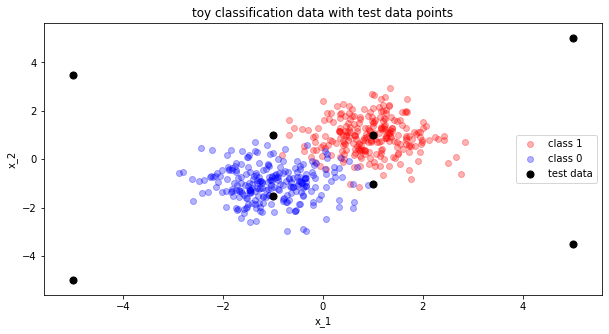

In [4]:
# Create the training DataSet
train_data = ClassificationDataSet(n_samples=500, mode='train')
train_gen = DataLoader(dataset = train_data, batch_size = 8, shuffle = False)
X, y, X_test = train_data.X, train_data.Y.flatten(), train_data.test_points

# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(X[y == 1, 0], X[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(X_test)):
    pt = X_test[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')

In [5]:
# Take a look at the architecture of Classification_NN
Classification_relu()

Classification_relu(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=2, bias=True)
)

In [6]:
# Initialize SWAG
swag = SWAG(Classification_relu, K = 10)
print("Total number of parameters for the NN is:", swag.weigt_D)

# Compile swag
objective = 'classification'
lr = 3e-3
swa_const_lr = 1
momentum = 0.9
optimizer = optim.SGD
loss_fn = nn.CrossEntropyLoss()
swa_scheduler = LambdaLR
swag.compile(objective, lr, swa_const_lr, momentum, optimizer, loss_fn, swa_scheduler)

# Fit swag
first_mom, second_mom, D = swag.fit(train_gen,
                                    train_epoch=30,
                                    swag_epoch=20,
                                    log_freq=60,
                                    verbose=False)

/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Total number of parameters for the NN is: 42
Begin NN model training...

Begin SWAG training...


**Uncertainty Measurement**

One way to approximate the model uncertainty, is by measuring the variance (or standard deviation) of the model predictions for each point. We can repeatedly draw samples from the SWAG weights posterior to form a distribution over predictions for each point. The expected behavior is that, for the OOD points, the variance of predictions should be higher than for the in-sample points. The precise defition on uncertainty, $U$, in this case is:

$$
U(y) = Var(\{\hat{y_i}, i\in ~[1,2,3,...S]\})
$$

where $y$ is the origianl data point, $y_i$ is the $i^{th}$ prediction using a particular set of sample weights, and $S$ is the number of sample weights drawn from the posterior formed by SWAG.

To measure this uncertainty, we wrote a function that, in prediction time, perserves all of the predictions using each of the sampled weights.

../code/util.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  curr_params = torch.tensor(params_1d[pointer:pointer+length]).reshape(shape)


Shape of the expanded prediction:
 (100, 8, 2)
Predictions for each point using the 1st sample weights:
 [[9.99198496e-01 8.01559887e-04]
 [2.17321576e-04 9.99782741e-01]
 [1.00000000e+00 5.53936008e-09]
 [1.68384051e-13 1.00000000e+00]
 [9.90776360e-01 9.22370516e-03]
 [5.91325238e-02 9.40867484e-01]
 [2.36127093e-01 7.63872921e-01]
 [6.94613218e-01 3.05386692e-01]]

Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0000
Test point: (1, 1) 	Variance in prediction: 0.0000
Test point: (-5, -5) 	Variance in prediction: 0.0000
Test point: (5, 5) 	Variance in prediction: 0.0000
Test point: (-5, 3.5) 	Variance in prediction: 0.0291
Test point: (5, -3.5) 	Variance in prediction: 0.0736
Test point: (-1, 1) 	Variance in prediction: 0.0979
Test point: (1, -1) 	Variance in prediction: 0.2016


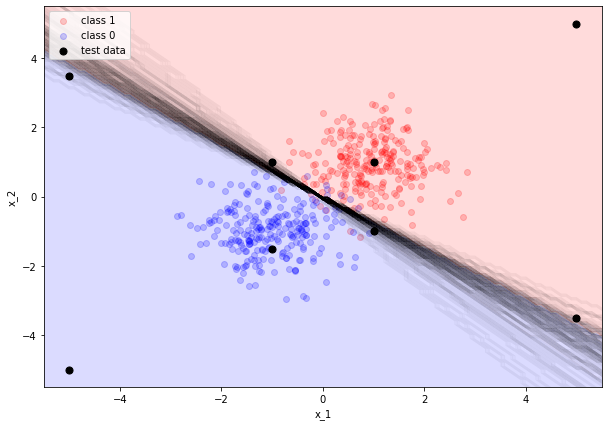

In [7]:
# Sample 1000 posterior weights
expand_pred = swag.predict(torch.Tensor(X_test), [0, 1], S=100, expanded=True)
print("Shape of the expanded prediction:\n", expand_pred.shape)
print("Predictions for each point using the 1st sample weights:\n", expand_pred[0])

# Measure Uncertainty
uncertainty_measurement(X_test, expand_pred)

# Plot decision boundaries
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plot_decision_boundary(swag, X, y, ax, xlim=6, n_models=100, poly_degree=1, test_points=X_test, shaded=True)

From the above uncertainty measurements, we see that the uncertainties are only positive for the 4 data points that lie right on top of the decision boundary, while the 2 off-diagnol OOD points have no uncertainty whatsoever, which is undesirable. Also, it should be noted that the two OOD points that are right on top of the somewhat linear decision boundaries just happened to have non-trivial uncertainties because of the shape of the decision boundary. This means that the model assigned a pretty high aleatoric uncertainty, rather than epistemic uncertainty, as it should have.

To counter this problem, we have explored a number of possibilities
1. use different activation functions - the intuition is that using different activation function could produce different decision boundaries, some of which might produce better uncertainty measurements
2. perform the pre-training for less epochs - the idea is that if the pre-trained model is already overfitted, then the swag inference will tend to produce very similar results, so underfitting the pre-trained model could potentially produce more desirable uncertainty measurements
3. experiment with the learning rate for swag inference - the idea is that if we vary the learning rate during swag inference, the model might explore more or less of the subspace formed by the NN weights, which could yield better uncertainty measurements
4. change the parameter $K$, which controls the number of columns within the deviation matrix $D$ of the swag algorithm. A larger $K$ could mean that there will be more variance within the sampled weights

The result of experiments 1 revealed no significant difference between the different activation functions, while the result of experiment 4 showed that increasing $K$ could only amplify the already existing uncertainties but failed to assign uncertainties to all OOD observations. These results are less insightful and will be displayed in **Appendix A**. Below, we display the results for experiment 2 and 3.

**Experiment 2. Underfitting the pre-trained model**  
We explore underfitting the pre-trained model to see if this will mitigate the undesirable uncertainty measurements. We will employ the `Classification_the sigmoid` model since, compared to the other two NNs, its ability to produce desirable uncertainty measurements is slightly better (refer to `Appendix A - Experiment 1` for more details).

Total number of parameters for the NN is: 42
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0000
Test point: (1, 1) 	Variance in prediction: 0.1275
Test point: (-5, -5) 	Variance in prediction: 0.0000
Test point: (5, 5) 	Variance in prediction: 0.1275
Test point: (-5, 3.5) 	Variance in prediction: 0.2400
Test point: (5, -3.5) 	Variance in prediction: 0.2451
Test point: (-1, 1) 	Variance in prediction: 0.1600
Test point: (1, -1) 	Variance in prediction: 0.2016

Plotting the decision boundaries...


../code/util.py:97: UserWarning: No contour levels were found within the data range.
  ax.contour(x1, x2, yy, colors='black', linewidths=linewidths, alpha=alpha_line)


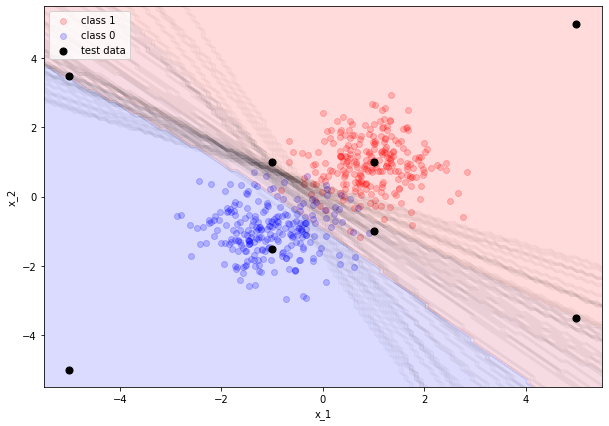

In [8]:
# Train for 7 epochs
swag = swag_trainer(Classification_sigmoid, train_epoch=7, n_models=50)

In [9]:
# Predicting all X_test
for i in range(10):
    preds = swag.predict(torch.Tensor(X_test), [0, 1], S=1, expanded=False)
    print("Trail", i, ', Predictions:', preds)

Trail 0 , Predictions: [0 1 0 1 0 1 1 1]
Trail 1 , Predictions: [0 1 0 1 1 0 1 0]
Trail 2 , Predictions: [0 0 0 0 0 0 0 0]
Trail 3 , Predictions: [0 1 0 1 0 1 1 1]
Trail 4 , Predictions: [0 1 0 1 1 0 1 0]
Trail 5 , Predictions: [0 1 0 1 0 1 1 1]
Trail 6 , Predictions: [0 1 0 1 1 0 1 0]
Trail 7 , Predictions: [0 1 0 1 0 1 0 1]
Trail 8 , Predictions: [0 1 0 1 0 1 1 0]
Trail 9 , Predictions: [0 1 0 1 1 0 1 0]


In [10]:
# Predicting just one point
pt = (1, 1)
point_pred = swag.predict(torch.Tensor(pt).view(1,-1), [0, 1], S=100, expanded=True)[:, 0, :]
point_pred = np.argmax(point_pred, axis=1)
print(f"For {pt}, mean prediction: {np.mean(point_pred):.4f}, var of predictions: {np.var(point_pred):.4f}")

pt = (5, 5)
point_pred = swag.predict(torch.Tensor(pt).view(1,-1), [0, 1], S=100, expanded=True)[:, 0, :]
point_pred = np.argmax(point_pred, axis=1)
print(f"For {pt}, mean prediction: {np.mean(point_pred):.4f}, var of predictions: {np.var(point_pred):.4f}")

For (1, 1), mean prediction: 0.8100, var of predictions: 0.1539
For (5, 5), mean prediction: 0.8100, var of predictions: 0.1539


From the above experiments, we find that underfitting the pre-tarined model is not a good idea. This is because even though underfitting might be able to produce more "curved" decision bounaries (which could be desirable), the recontructed NN also tends to be more unstable as the sampled posterior weights will produce enitrely non-sensible results such as predicting all 1s or all 0s for the test points. This is evident form the above two calulations:
- For repeated predictions of all test points, we see some big stability issues with the model since we observe some predictions to be all 0s or all 1s
- `(1, 1), (5, 5)` are two points that the model should seemingly be really certain of, but their uncertainties are not zero, which indicates that the model suffers from unstability

We have two hypotheses that could explain this observation:
1. for neural network models in general, the non-linear relationships between the neurons in the hidden layers are so complex that sometimes even a small tweek in the model weights will make the predictions non-sensible
2. due to the stochasticity of the SWAG model, sometimes the sampled the posterior weights could deviation from the pre-trained weights by a substantial amount that the re-constructed NN will produce non-sensible results

**Experiment 3. SWAG learning rate**

Another paramter that we could experiment with is the learning rate during SWAG inference. In the original paper, the author proposed using a constant learning rate for the SWAG inference to explore the subspace formed by the posterior of NN weights. In our original implementation, we used a constant learning rate of 1, but now we could try larger learning rates to see if the exploration could be more thorough.

Total number of parameters for the NN is: 42
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0000
Test point: (1, 1) 	Variance in prediction: 0.0196
Test point: (-5, -5) 	Variance in prediction: 0.0000
Test point: (5, 5) 	Variance in prediction: 0.0196
Test point: (-5, 3.5) 	Variance in prediction: 0.2491
Test point: (5, -3.5) 	Variance in prediction: 0.2244
Test point: (-1, 1) 	Variance in prediction: 0.0651
Test point: (1, -1) 	Variance in prediction: 0.2484

Plotting the decision boundaries...


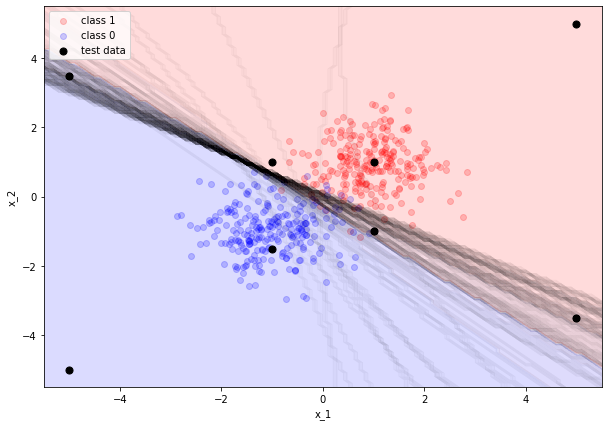

In [11]:
swag = swag_trainer(Classification_sigmoid, swa_const_lr=3)

Total number of parameters for the NN is: 42
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0819
Test point: (1, 1) 	Variance in prediction: 0.0196
Test point: (-5, -5) 	Variance in prediction: 0.0475
Test point: (5, 5) 	Variance in prediction: 0.0196
Test point: (-5, 3.5) 	Variance in prediction: 0.1924
Test point: (5, -3.5) 	Variance in prediction: 0.2379
Test point: (-1, 1) 	Variance in prediction: 0.0196
Test point: (1, -1) 	Variance in prediction: 0.2496

Plotting the decision boundaries...


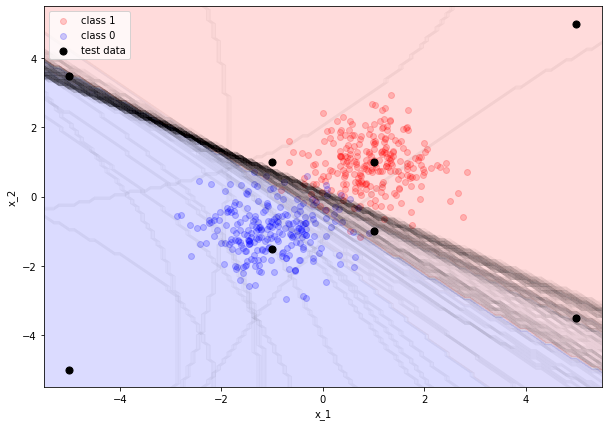

In [12]:
swag = swag_trainer(Classification_sigmoid, swa_const_lr=5)

From the above results, we see that change the SWAG inference learning rate can only amplify the test points that already have a reasonable uncertainty, but cannot correctly assign uncertainties to those points that should have been assigned a non-trival uncertainty. Also, if the learning rate is too large, the resulting model is highly unstable, yielding one-sided predictions of all 0s or 1s and non-sensible uncertainty measures.

**Further Explorations**

In additional to the simple two-cluster dataset, we would like to apply SWAG on a more interesting dataset, Two Moons (Pedregosa et al., 2011), to see how the posterior inference behaves in cases where the decision boundary is more complex.

In this experiment, we designed the following test points:
- `(1, -.5), (0, 1)`: in-distribution samples, should be classified corrected with high certainty
- `(-0.5, 0.25), (0.5, 0.25), (1.5, 0.25)`: in-distribution samples, selected to evaluate the model's ability to capture aleatoric uncertainties since they lie on top of the decision boundary of the two classes
- `(-1, -1,5), (-1, 1.5), (2, -1.5), (2, 1.5)`: OOD samples, designed to test model's ability to capture epistemic uncertainty and should be assigned high uncertainty in prediction

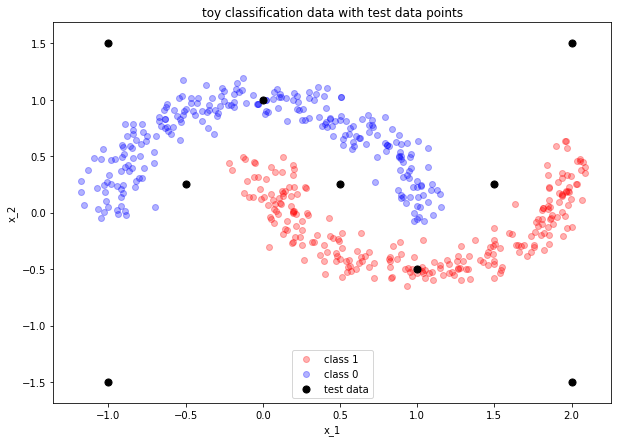

In [13]:
# Create the training DataSet
train_data = TwoMoons(n_samples=500, mode='train', noise=0.1)
train_gen = DataLoader(dataset = train_data, batch_size=32)
X, y, X_test = train_data.X, train_data.Y.flatten(), train_data.test_points

# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.scatter(X[y == 1, 0], X[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(X_test)):
    pt = X_test[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')

Total number of parameters for the NN is: 70
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (1, -0.5) 	Variance in prediction: 0.0000
Test point: (0, 1) 	Variance in prediction: 0.0000
Test point: (-0.5, 0.25) 	Variance in prediction: 0.0000
Test point: (0.5, 0.25) 	Variance in prediction: 0.0099
Test point: (1.5, 0.25) 	Variance in prediction: 0.0000
Test point: (-1, -1.5) 	Variance in prediction: 0.0000
Test point: (-1, 1.5) 	Variance in prediction: 0.0000
Test point: (2, -1.5) 	Variance in prediction: 0.0000
Test point: (2, 1.5) 	Variance in prediction: 0.0000

Plotting the decision boundaries...


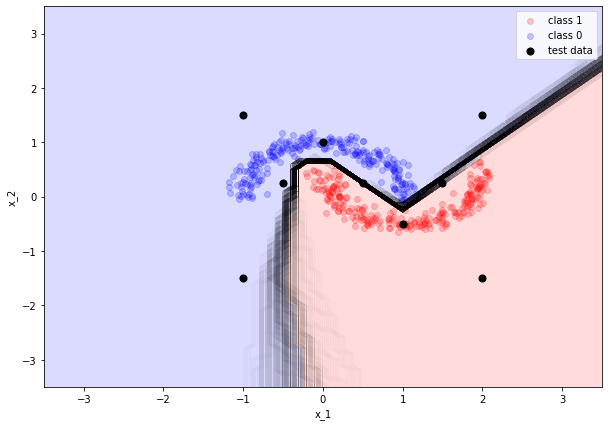

In [14]:
# Classification_relu_8 - a more complex NN is used to capture the more complex relationships
swag = swag_trainer(Classification_relu_8, train_epoch=80, verbose=False, log_freq=10, xlim=4)

From the uncertainty measures and the plot of decision boundaries, we see that the model is able to separate the data quite well, however, the model did not bother to form any curvature around the dataset and just did the "bare minimum" to separate the two classes. Again, the OOD points do not have any epistemic uncertainties, and even the points desinged to test model aleatoric uncertainties do not have non-trivial uncertainties in their predictions. This means that, again, SWAG failed to produce desirable uncertainty measurements and still suffers from the shortcoming discussed above.

**Conclusion**

In the above section, we have thoroughly explore the ability of SWAG to produce uncertainty measurements. The overall result is not perfect, as the model is only able to capture aleatoric uncertainty (as well as those points that happen to lie right on top of the linear decision boundary), but not the epistemic uncertainty for OOD test points.

This analysis points out several important limitations of the SWAG algorithm:
- Due to the **"black box" nature of NN models**, it is hard for us to understand the effect of changing the model parameters, which means **the expected behavior** of approximating the posterior of NN weights as a multivariate normal distirbution and then sample from it **is very hard to predict**. As we have seen from the examples above, the re-constrcuted model using sampled weights could sometimes be highly unstable and yield non-sensible predictions like all 0s or all 1s (predicting all observations belonging to the same class)
- It is well knowm that **NN models has the potential to overfit to the training data**, and this is indeed what we observe. If the pre-trained model is too overfitted, then the SWAG inference step could only **produce models that are very similar to the original model**, which undermines the SWAG model's ability to capture the desired amount of uncertainty
- The ability of the SWAG model to capture uncertainty is ultimately bounded by the shape of decision boundaries that the original NN could form. An interesting observation is that **NN models**, even with their ability to form arbitrarily complex decision boundaries, do not tend to produce decision boundaries that "surrounds" the data points, but rather **tend to produce pretty simple decision boundaries (e.g., linear) that best separates the data**. Therefore, to better capture uncertainty for this particular toy dataset, we should probably use higher order polynomial transformation of the features
- Even though the uncertainty measurements were not ideal, we learned that to **increase the spread of the model predictions**, we could **crank up `$K$` or the `SWAG inference learning rate`** to achieve this. However, underfitting the pre-trained model is almost always not a good idea.

## 2.  Classification: Performance and uncertainty Measurements of CIFAR-10

### 2.1 Classification performace in task of classifying 10 categories

#### 2.1.1 Classification accuracy for a model without SWAG

The paper claims that the test accuracies of SWAG on the several image datasets typically outperforms all the baseline models in terms of accuracy.

In the below section, we will train a model on the dataset CIFAR-10. The CIFAR-10 dataset is a collection of images that are commonly used to train machine learning and computer vision algorithms:
1. It contains 60,000 32x32 color images in 10 different classes. 
2. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. 
3. There are 6000 images of each class.

We split the dataset into training and testing set, where the training set contrains 50000 images and the test set contains 10000 images.

Due to the computational power limit, we are going to train a Simple Convolutional Neural network with the following architecture.

In [2]:
## Load train-test data
transform_train = transforms.Compose([
    transforms.Resize((40, 40)),       
    transforms.RandomCrop((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=3,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=3,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


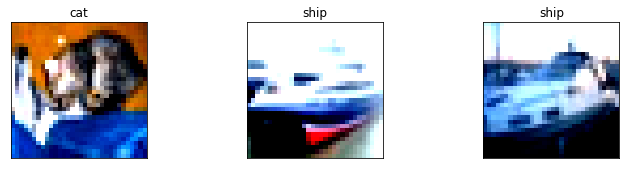

In [3]:
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

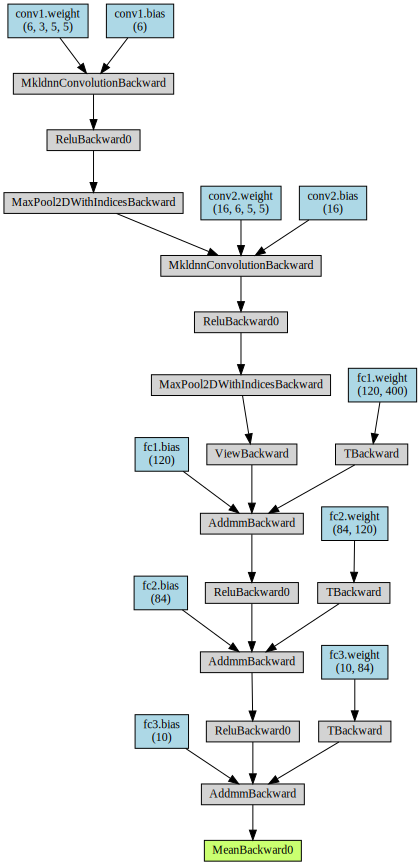

In [4]:
net = Net()
dataiter = iter(trainloader)
images, labels = dataiter.next()
y = net(images)
make_dot(y.mean(),params = dict(net.named_parameters()))

In [5]:
# Use the Classification Cross-Entropy loss and Adam optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
model_directory_path = '../model/'
model_path = model_directory_path + 'cifar-10-cnn-model.pt'
net.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [7]:
confusion_matrix,acc = test_accuracy(net,testloader,classes)

Model accuracy on 10000 test images: 53.07%


In [8]:
accuracy_class(confusion_matrix, classes)

Category   - Accuracy
plane      - 51.1
car        - 76.4
bird       - 27.1
cat        - 37.5
deer       - 41.9
dog        - 27.6
frog       - 75.3
horse      - 63.8
ship       - 70.2
truck      - 59.8


#### 2.1.2 Classification accuracy for a model with SWAG

In [9]:
swag = SWAG(Net, 3, True, net)

/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


In [10]:
# Compile swa
objective = 'classification'
lr = 1e-3
momentum=0.9
optimizer = optim.SGD
loss_fn = nn.CrossEntropyLoss()
swa_scheduler = LambdaLR

swag.compile(objective, lr,1, momentum, optimizer, loss_fn, swa_scheduler)

In [11]:
model_directory_path = '../model/'
model_path = model_directory_path + 'cifar-10-cnn-swag-model.pt'
new_net = Net()
new_net.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [12]:
# Overall accuracy
confusion_matrix_swag,_ = test_accuracy(new_net,testloader,classes)

Model accuracy on 10000 test images: 57.20%


In [13]:
accuracy_class(confusion_matrix_swag,classes)

Category   - Accuracy
plane      - 51.7
car        - 74.5
bird       - 32.0
cat        - 21.7
deer       - 39.7
dog        - 50.9
frog       - 82.5
horse      - 66.6
ship       - 80.6
truck      - 71.8


From the above results, we trained 3 epochs on our simple CNN models and got overall accuracy of 53.07% on the test set classification task. After that, we used the weights of the trained network as initial value of the SWAG weights and performed swag algorithm for 5 epochs. We see that the accuracy has increased around 4% to 57.20%. Indeed, the SWAG algorithm is capable of outperforming the baseline model in terms of accuracy in this case.

### 2.2 Classification performace in task of classifying 2 categories

From the above experiment, we verify that SWAG algorithm is capable of outperforming the baseline model in terms of accuracy on a simple neural network model. We will train a model to only classify dogs and cats and see if SWAG is able to improve the performace of a model that has pretty good test accuracy.

In [2]:
# Transformations
RC   = transforms.RandomCrop(32, padding=4)
RHF  = transforms.RandomHorizontalFlip()
RVF  = transforms.RandomVerticalFlip()
NRM  = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
TT   = transforms.ToTensor()
TPIL = transforms.ToPILImage()

# Transforms object for trainset with augmentation
transform_with_aug = transforms.Compose([TPIL, RC, RHF, TT, NRM])
# Transforms object for testset with NO augmentation
transform_no_aug   = transforms.Compose([TT, NRM])

# Downloading/Louding CIFAR10 data
trainset  = CIFAR10(root='./data', train=True , download=True)#, transform = transform_with_aug)
testset   = CIFAR10(root='./data', train=False, download=True)#, transform = transform_no_aug)
classDict = {'plane':0, 'car':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}

# Separating trainset/testset data/label
x_train  = trainset.data
x_test   = testset.data
y_train  = trainset.targets
y_test   = testset.targets

# Choose only cats (class 3 of CIFAR) and dogs (class 5 of CIFAR) as trainset/testset
cat_dog_trainset = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['cat']), get_class_i(x_train, y_train, classDict['dog'])],
        transform_with_aug
    )
cat_dog_testset  = \
    DatasetMaker(
        [get_class_i(x_test , y_test , classDict['cat']), get_class_i(x_test , y_test , classDict['dog'])],
        transform_no_aug
    )

kwargs = {'num_workers': 2, 'pin_memory': False}

# Create datasetLoaders from trainset and testset
trainsetLoader   = DataLoader(cat_dog_trainset, batch_size=4, shuffle=True , **kwargs)
testsetLoader    = DataLoader(cat_dog_testset , batch_size=4, shuffle=False, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 1, 0, 0])
  Dog   Dog   Cat   Cat


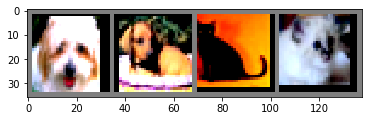

In [3]:
classes = ['Cat','Dog']
# get some random training images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(trainsetLoader)
images, labels = dataiter.next()

# print labels
print(labels)
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# show images
imshow(torchvision.utils.make_grid(images))

#### 2.2.1 Classification performace of a model without SWAG

In [4]:
model = CNN()
model_directory_path = '../model/'
model_path = model_directory_path + 'cifar-10-cnn-catdog2-model.pt'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [5]:
confusion_matrix_catdog,_ = test_accuracy(model,testsetLoader,classes)

Model accuracy on 2000 test images: 84.45%


In [6]:
accuracy_class(confusion_matrix_catdog,classes)

Category   - Accuracy
Cat        - 87.2
Dog        - 81.7


#### 2.2.2 Classification performace of a model with SWAG

In [10]:
model_directory_path = '../model/Swag/'
model_path = model_directory_path + 'model_swag0.pt'
model_swag,swag = train_swag(model, model_path)

Loaded model parameters from disk.


In [11]:
classes = ['Cat','Dog']
confusion_matrix_catdog_swag,_ = test_accuracy(model_swag,testsetLoader,classes)

Model accuracy on 2000 test images: 85.80%


In [13]:
accuracy_class(confusion_matrix_catdog_swag, classes)

Category   - Accuracy
Cat        - 85.3
Dog        - 86.3


### 2.3 Average Accuracy

#### 2.3.1 Swag models

Since SWAG algorithm involves randomess, we will perform SWAG algorithm on the original model 10 times and calculate the average test accuracy on those models.

In [ ]:
Swag_models = []
Swag_models.append(model_swag)
for i in range(1,10):
    model_directory_path = '../model/Swag/'
    model_path = model_directory_path + 'model_swag'+ str(i) + '.pt'
    model_swag,swag = train_swag(model, model_path)
    Swag_models.append(model_swag)

In [15]:
Acc_swag = []
for i in range(10):
    _,acc= test_accuracy(Swag_models[i],testsetLoader,classes)
    Acc_swag.append(acc)

Model accuracy on 2000 test images: 85.80%
Model accuracy on 2000 test images: 85.60%
Model accuracy on 2000 test images: 86.15%
Model accuracy on 2000 test images: 85.35%
Model accuracy on 2000 test images: 85.60%
Model accuracy on 2000 test images: 85.25%
Model accuracy on 2000 test images: 84.20%
Model accuracy on 2000 test images: 85.00%
Model accuracy on 2000 test images: 85.40%
Model accuracy on 2000 test images: 84.95%


In [16]:
np.mean(Acc_swag)

85.33

#### 2.3.2 Ensemble models without Swag

In order to make the above results comparable, we will also perform an ensemble of the CNN model (consisting of 10 CNN with different initializations but same architecture) and compute the average classificaiton accuracy on the test set.

In [17]:
model_sample = model

In [18]:
CNN_models = []
CNN_models.append(model)
for i in range(1,10):
    model_cnn = CNN()
    model_directory_path = '../model/CNN/'
    model_path = model_directory_path + 'model_CNN'+ str(i) + '.pt'
    if not os.path.exists(model_directory_path):
        os.makedirs(model_directory_path)
    if os.path.isfile(model_path):
        # load trained model parameters from disk
        model_cnn.load_state_dict(torch.load(model_path))
        print('Loaded model parameters from disk.')
    else:
        optimizer = optim.SGD(model_cnn.parameters(), lr=0.001, momentum=0.9)
        device = torch.device("cpu") 
        losses = []
        accuracies = []
        for epoch in range(0, 20):
            losses.extend(train(model_cnn, device, trainsetLoader, optimizer, epoch))
            accuracies.append(test(model_cnn, device, trainsetLoader))
        torch.save(model_cnn.state_dict(), model_path)
    CNN_models.append(model_cnn)

Loaded model parameters from disk.
Loaded model parameters from disk.
Loaded model parameters from disk.
Loaded model parameters from disk.
Loaded model parameters from disk.
Loaded model parameters from disk.
Loaded model parameters from disk.
Loaded model parameters from disk.
Loaded model parameters from disk.


In [19]:
Acc_CNN = []
for i in range(10):
    _,acc= test_accuracy(CNN_models[i],testsetLoader,classes)
    Acc_CNN.append(acc)

Model accuracy on 2000 test images: 79.60%
Model accuracy on 2000 test images: 79.75%
Model accuracy on 2000 test images: 82.80%
Model accuracy on 2000 test images: 81.70%
Model accuracy on 2000 test images: 83.80%
Model accuracy on 2000 test images: 82.55%
Model accuracy on 2000 test images: 82.35%
Model accuracy on 2000 test images: 82.55%
Model accuracy on 2000 test images: 83.40%
Model accuracy on 2000 test images: 83.55%


In [20]:
np.mean(Acc_CNN)

82.205

From the above resuls. By comparing the test accuracy of models calculated by the SWAG algorithm and the average of 10 ensemble models with different initialization weights. We see that:
1. Average test accuracy of SWAG model is 85.33% 
2. Average test accuracy of Ensemble models is 82.69%

As a result, We may believe that the SWAG algorithm is capable of outperforming the baseline model in terms of accuracy.

### 2.4 Uncertainty Measurements of CIFAR-10

What's more important is that we want to measure if the SWAG algorithm is able to help the model to detect the out-of-distribution samples. 

We will interpret the output of our Neural Network Model - the classification probability - as an indicator of the confidence of the model when it is classifying a specific data point. Specifically, we will only train the model on 2 categories of the image (e.g. when the probability is close to 0.5, we say that the model is not confident in classifying the data point as class 1 or 0).

After training the model via SWAG algorithm, we are able to draw sets of parameters and form a posterior distribution of the model. As a result, we will apply those models on a predefined set of test images (some of them are OOD samples) and check the classification probability again.

We will first fixed a test that contains both in-distribution samples and out-of-distribution samples. We will select 5 images from all different classes.

In [21]:
# Fixed a test
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 
           'frog', 'horse', 'ship', 'truck')
images_ls = {}
label_ls = {}
for i in classes:
    images, labels = test_sample(i)
    images_ls[i] = images
    label_ls[i] = labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


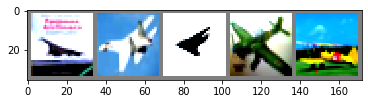

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


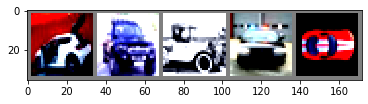

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


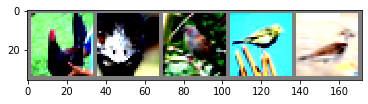

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


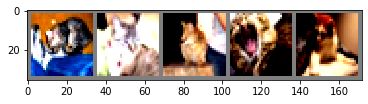

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


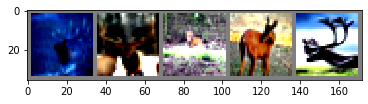

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


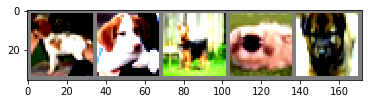

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


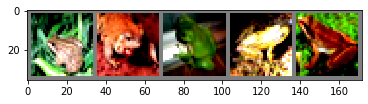

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


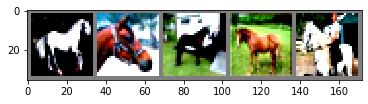

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


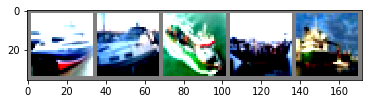

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


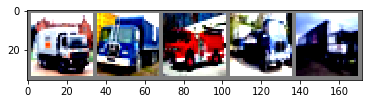

In [22]:
for i in classes:
    imshow(torchvision.utils.make_grid(images_ls[i]))

#### 2.4.1 Sample from SWAG Posterior Distribution

In [24]:
model_directory_path = '../model/Moments/'
model_path1 = model_directory_path + 'first_mom.npy'
model_path2 = model_directory_path + 'second_mom.npy'
model_path3 = model_directory_path + 'D.npy'

# Initalize the swag
model_swag = CNN()
swag = SWAG(CNN, 5, True, model)

if not os.path.exists(model_directory_path):
        os.makedirs(model_directory_path)
if os.path.isfile(model_path1):
    # load trained model parameters from disk
    first_mom = np.load(model_path1)
    swag.first_mom = first_mom
    print('Loaded first_mom from disk.')
if os.path.isfile(model_path2):
    # load trained model parameters from disk
    second_mom = np.load(model_path2)
    swag.second_mom = second_mom
    print('Loaded second_mom from disk.')
if os.path.isfile(model_path3):
    # load trained model parameters from disk
    D = np.load(model_path3)
    swag.D = D
    print('Loaded D from disk.')
else:
    torch.manual_seed(seed)
    np.random.seed(seed)
    # Compile swa
    objective = 'classification'
    lr = 1e-3
    momentum=0.9
    optimizer = optim.SGD
    loss_fn = nn.CrossEntropyLoss()
    swa_scheduler = LambdaLR
    swag.compile(objective, lr,1, momentum, optimizer, loss_fn, swa_scheduler)
    # Fit swag
    first_mom, second_mom, D = swag.fit(trainsetLoader,
                                        train_epoch=0,
                                        swag_epoch=5,
                                        log_freq=500,
                                        pretrained = True)
    np.save(model_path1, first_mom)
    np.save(model_path2, second_mom)
    np.save(model_path3, D)



Loaded first_mom from disk.
Loaded second_mom from disk.
Loaded D from disk.


In [25]:
# Sample from the posterior distribution
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
# Generate weight samples
S = 1000
weight_samples = []
for i in range(S):
    samples = swag.weight_sampler()
    weight_samples.append(samples)

# Recreate Models:
swag_models = []
for s, weight_param in enumerate(weight_samples):
    model_params = params_1d_to_weights(weight_param, swag.shape_lookup, swag.len_lookup)
    new_net = create_NN_with_weights(swag.NN_class, model_params)
    swag_models.append(new_net)

../code/util.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  curr_params = torch.tensor(params_1d[pointer:pointer+length]).reshape(shape)


In [26]:
# Prepare In-distribution and OOD samples.
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
Prediction_var = {}
sm = torch.nn.Softmax()
for i in classes:
    data = images_ls[i]
    prediction_ls = []
    for j in swag_models:
        outputs=j(data)
        prob = sm(outputs) 
        Prediction = np.argmax(prob.detach().numpy(),axis = 1)
        prediction_ls.append(Prediction)
    Prediction_var[i] = np.var(prediction_ls,axis = 0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


#### 2.4.2 Bacoun uncertainty measurement

In this section, I will implement an uncertainty estimation method from the paper "BaCOUn: Bayesian Classifers with Out-of-Distribution Uncertainty" (https://arxiv.org/pdf/2007.06096.pdf)

Ideally, we should expect to see higher epistemic uncertaintity for instances for held-out classes (classes other than cat and dog) compared to the uncertainty for in-distribution points. (class cat and dog). On the other hand, points from those held-out classes should also have comparable aleatoric uncertainty to in-distribution samples.

The paper states the following point: Given an ensemble of models (such as the models obtained by sampling from the posterior distribution over the parameters of a BNN), the entropy of the posterior predicted Categorical distribution is a measure of the total predictive uncertainty.
The total uncertainty can be further decomposed into: aleatoric uncertainty, arising due to noise, and epistemic uncertainty, arising due to lack of knowledge when no data are observed on a given region of the feature space. We can calculate the expected entropy at a given point by averaging the entropies of the Categorical distributions predicted by each member of the ensemble. This is a measure of aleatoric uncertainty in predicting a single point. Finally, the Mutual Information (MI) between the categorical label y and the pa- rameters of the model W (i.e. in deep learning models these are the weights of the network), calculated by subtracting the expected entropy from total entropy, is a measure of the spread of the ensemble, and in turn a measure of epistemic uncertainty.

Mathematcially, it can be expressed as following:

$$
\begin{aligned}
I(y,W\mid x^{*},D) &= \mathbb{H}[\mathbb{E}_{p(W\mid D)}[p(y\mid x^{*},W)]\\
&- \mathbb{E}_{p(W\mid D}[\mathbb{H}[p(y\mid x^{*},W]]\\
\end{aligned}
$$

In [33]:
def entropy(p):
    return -sum([p[i] * np.log(p[i]) for i in range(len(p))])

#### Total Uncertainty (Entropy of the predicted Categorical distribution)

In [35]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
Total_uncetainty = {i:None for i in classes}
sm = torch.nn.Softmax()
for i in classes:
    data = images_ls[i]
    for k in data:
        prob_sample = []
        avg_prob = []
        for j in swag_models:
            outputs=j(k.reshape(-1,3,32,32))
            prob = sm(outputs).detach().numpy()
            prob_sample.append(prob)
        avg_prob.append(np.mean(prob_sample,axis = 0))
    Total_uncetainty[i]= entropy(np.array(avg_prob))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


In [36]:
Total_uncetainty

{'plane': 0.67351097,
 'car': 0.67746246,
 'bird': 0.5495795,
 'cat': 0.61822236,
 'deer': 0.66428834,
 'dog': 0.6898838,
 'frog': 0.6156498,
 'horse': 0.691476,
 'ship': 0.5045874,
 'truck': 0.6908481}

#### Aleatoric uncertainty

In [37]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
Entropy_ind = {i:[] for i in classes}
Aleatoric_uncetainty = {i:None for i in classes}
sm = torch.nn.Softmax()
for i in classes:
    data = images_ls[i]
    for k in data:
        entro_sample = []
        for j in swag_models:
            outputs=j(k.reshape(-1,3,32,32))
            prob = sm(outputs).detach().numpy()
            entro = entropy(prob)
            entro_sample.append(entro)
        Entropy_ind[i].append(np.array(entro_sample))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


In [38]:
Aleatoric_uncetainty = {i:np.mean(Entropy_ind[i]) for i in classes}
Aleatoric_uncetainty

{'plane': 0.396947,
 'car': 0.4617724,
 'bird': 0.3567254,
 'cat': 0.38524932,
 'deer': 0.4708209,
 'dog': 0.35279906,
 'frog': 0.41072968,
 'horse': 0.4616059,
 'ship': 0.40194973,
 'truck': 0.46503505}

#### Epistemic Uncertainty

In [39]:
Ep_uncertainty = {i:(Total_uncetainty[i] - Aleatoric_uncetainty[i]) for i in classes}
Ep_uncertainty

{'plane': 0.27656397,
 'car': 0.21569005,
 'bird': 0.1928541,
 'cat': 0.23297304,
 'deer': 0.19346744,
 'dog': 0.33708477,
 'frog': 0.20492014,
 'horse': 0.22987008,
 'ship': 0.10263768,
 'truck': 0.22581306}

From above, the results for epistemic uncertainty is definitely not ideal. (i.e. The epistemic uncertainteis for dog and cat are actually higher than that of other categories). There are seveal possible reasons that might result in the above observations:
1. The model is not complex enough to classify dogs and cats, since it only achieves around 85% test accuracy. A more complex and power might be more desirable.
2. We only apply the model on 5 samples for each category due to the computational limitation, more samples might generate different results.
3. The SWAG algorithm simply is not good enough to train a model to detect the OOD samples. It could also be the case that the model is highly sensitive to hyperparameters and fine tuning would be necessary to make the algorithm works.

## Appendix

### A. Additional Experiments for `Classification: Uncertainty Measurements of a Toy Dataset`
This section records the experimental results for experiments 1 and 2:
1. use different activation functions - the intuition is that using different activation function could produce different decision boundaries, some of which might produce better uncertainty measurements
2. perform the pre-training for less epochs - the idea is that if the pre-trained model is already overfitted, then the swag inference will tend to produce very similar results, so underfitting the pre-trained model could potentially produce more desirable uncertainty measurements

**Experiment 1. Different activation functions**

In [14]:
# Reload ClassificationDataSet
train_data = ClassificationDataSet(n_samples=500, mode='train')
train_gen = DataLoader(dataset = train_data, batch_size = 8, shuffle = False)
X, y, X_test = train_data.X, train_data.Y.flatten(), train_data.test_points

Total number of parameters for the NN is: 42
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0000
Test point: (1, 1) 	Variance in prediction: 0.0000
Test point: (-5, -5) 	Variance in prediction: 0.0000
Test point: (5, 5) 	Variance in prediction: 0.0000
Test point: (-5, 3.5) 	Variance in prediction: 0.0000
Test point: (5, -3.5) 	Variance in prediction: 0.0000
Test point: (-1, 1) 	Variance in prediction: 0.2331
Test point: (1, -1) 	Variance in prediction: 0.2451

Plotting the decision boundaries...


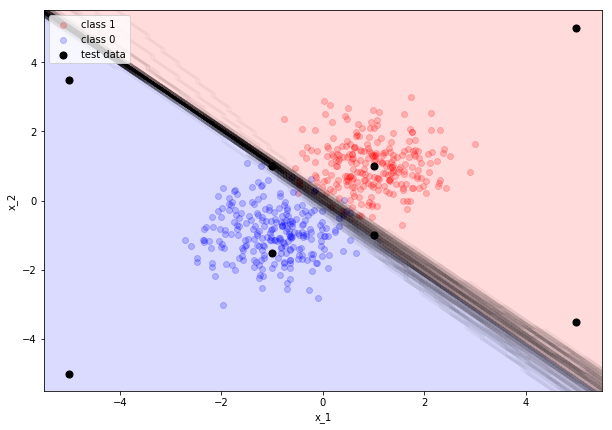

In [15]:
# Try sigmoid activation
swag = swag_trainer(Classification_sigmoid)

We can see from the above visualization as well as the uncertainty measurements that the uncertainties are not ideal, only capturing aleatoric uncertainties but failed to detect any of the OOD points. This means that using a different activation function could not solve our problem effectively.

**Experiment 4. K**

Finally, we will experiemnt with the parameter $K$, which controls the number of columns in the deviation matrix of the SWAG inference.

Total number of parameters for the NN is: 42
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0000
Test point: (1, 1) 	Variance in prediction: 0.0475
Test point: (-5, -5) 	Variance in prediction: 0.0000
Test point: (5, 5) 	Variance in prediction: 0.0475
Test point: (-5, 3.5) 	Variance in prediction: 0.0000
Test point: (5, -3.5) 	Variance in prediction: 0.0564
Test point: (-1, 1) 	Variance in prediction: 0.1659
Test point: (1, -1) 	Variance in prediction: 0.2464

Plotting the decision boundaries...


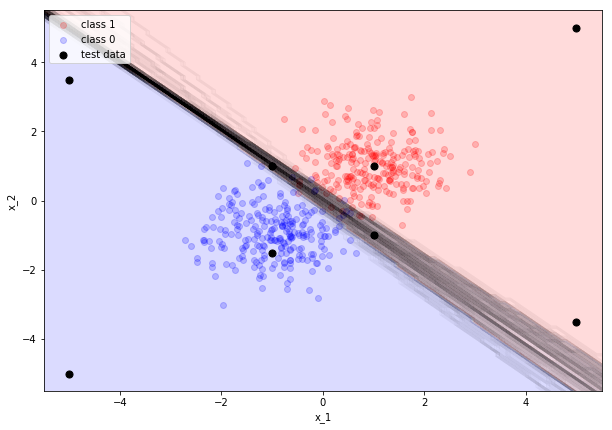

In [16]:
swag = swag_trainer(Classification_sigmoid, K=15)

From the above exploration, we see that increasing $K$ does have the effect of increasing the spread, or uncertainty, but the shapes of the decision boundaries do not change or the original one, which means we still failed to detect OOD observations.